# 1. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.stats.stattools
from scipy import stats

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

# Converting column dtypes

In [3]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year

In [4]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('str')

In [5]:
 #lambda function to extract the first character of each object and convert it to an int.
extract_num = lambda x: int(x[:2])

df['grade'] = df['grade'].apply(extract_num)

In [6]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

In [7]:
#df['yr_renovated'] = df['yr_renovated'].astype(int)

In [8]:
# 1 is not renovated
df['renovated'] = (df['yr_renovated'] == 0).astype(int)
df['renovated'] = df['renovated'].map({1: 0, 0: 1})

In [9]:
df['renovated'].value_counts()

0    28783
1     1372
Name: renovated, dtype: int64

# Filtering out rows not in King County

In [10]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

#### URL for King County Coordinate info
[King County Coordinates](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [11]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

# Dropping Null, Duplicate, Dropping Possible high Corrilinearity and Unecessary Columns

In [12]:
df_king.drop_duplicates(inplace=True)

In [13]:
df_king.dropna(inplace=True)
#df_king.info()

In [14]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_king.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [15]:
#print(df[(df.cc>.50) & (df.cc <1)])

In [16]:
df_king.drop(['id', 'address', 'sqft_above', 'sqft_basement', 'bathrooms', 'grade', 'bedrooms',
              'sqft_garage', 'floors'], axis=1, inplace=True)
#df_king.info()

# 2. Data Understanding

In [17]:
corr_matrix = df_king.corr(method='pearson')

#sns.set(font_scale=1.2)
#plt.figure(figsize=(16,8))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
#plt.title("Correlation Heatmap for King County Housing Data")
#plt.show()

# 3. Creating Simple Base Model

### Examining the heatmap, it appears that the Square Feet of Living Space in a home exhibits the strongest correlation coefficient with respect to housing prices. Consequently, using this feature as the basis for a model is logical, as one would intuitively assume that the size of a home, measured in square feet, significantly influences its price.

In [18]:
#sns.lmplot(data=df_king, x='sqft_living', y='price', hue='smoker')
#sns.regplot(data=df_king, x="sqft_living", y="price")
#plt.xlabel('SQFT Living')
#plt.ylabel('House Price per Mil')
#plt.title('Price vs SQFT Correlation');

#### Seems to be a clear relationship


In [19]:
y = df_king['price']
X = df_king['sqft_living']

base_model = sm.OLS(y, sm.add_constant(X)).fit()


print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.792e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:41:05   Log-Likelihood:            -4.3459e+05
No. Observations:               29197   AIC:                         8.692e+05
Df Residuals:                   29195   BIC:                         8.692e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.227e+04   9904.112     -9.317      

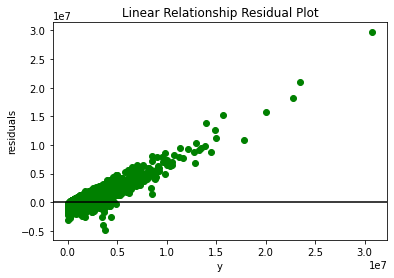

In [20]:
fig, ax = plt.subplots()

ax.scatter(y, base_model.resid, color="green")
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Linear Relationship Residual Plot");

In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(base_model.resid, sm.add_constant(X))

(343.0170136794241,
 1.4054878852769867e-76,
 347.07103414868413,
 5.152148079065719e-77)

#### Assumption Tests and Analysis:
- Passes **multicollinearity** with cond. no. 132 (under 1,000)
- Passes **independence** with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
- Fails **normality** Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
- Slightly skewed left
- 9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

# Assumption Testing 

## I. # Linearity Residual plots

In [22]:

# Partial regression plots
#fig, ax = plt.subplots(figsize=(12,8))
#sm.graphics.plot_partregress_grid(base_model, fig=fig)
#plt.show()

In [23]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(base_model)

(1.2167889998731811, 1.1605640760099133e-32)

## Based on our q-q plot and linear rainbow diagnostic we cann assume that our linear regression model has satisfied the Linear Assumptino

## II. **Normality Assumption**: Assumes that residuals or errors are normally distributed.

- The **Omnibus test** is used to detect normality assumption. A low probability value suggests that the distribution of errors or residuals is not normal. In this case, the p-value for the Omnibus test is 0.000 which means that we can reject the null hypothesis of normal distribution of residuals and conclude that the normality assumption is violated.
- **Jarque-Bera** (JB) test is also used to check for normality assumption. The JB test statistic measures whether the data has skewness or kurtosis values matching a normal distribution. If the test statistic is large and/or the p-value is low, then skewness and/or kurtosis are not similar to a normal distribution. With a very large test statistic of 50073454.459 and the p-value of 0.00, we can reject the null hypothesis of normality, indicating a violation of normality assumption.
- **Skewness** measures the degree of asymmetry of a probability distribution. A symmetrical distribution will have a skewness of 0. Positive skewness means there are more observations on the left side of the distribution, while negative means more observations on the right side. Here, the skewness value of 8.237 indicates positive skewness.
- **Kurtosis** measures the degree of peakness of a probability distribution. A normal distribution has a kurtosis of 3, and if it is greater than 3, it is said to be leptokurtic or heavy-tailed, and if it is less than 3, it is said to be platykurtic or light-tailed. The value of Kurtosis here is exceptionally high at 205.252 reflecting a severe deviation from normality.

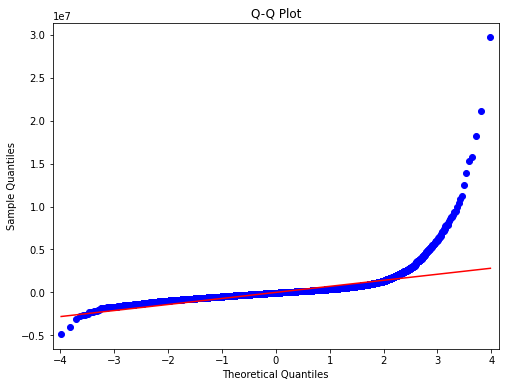

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [25]:
base_model.summary().tables[2]

Omnibus:,42260.401,Durbin-Watson:,1.938
Prob(Omnibus):,0.000,Jarque-Bera (JB):,50099131.216
Skew:,8.237,Prob(JB):,0.00
Kurtosis:,205.263,Cond. No.,5.63e+03


#### with omnibus and Jarque-Bera having small p-values this suggests that we cannot reject the null-hypothesis that the base model data is normally distributed.
#### Also with a Kurtosis greater than 3 this would suggest that the distribution is heavilyt tailed/spread out
#### Therefore this model does not pass normality assumption and we can not assume that this model is normally distributed

## III.Homoscedasticity Assumption: Assumes that the variance of residuals is constant across observations or independent variable values.
- need to look into this

In [26]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(base_model.resid, sm.add_constant(X))

(343.0170136794241,
 1.4054878852769867e-76,
 347.07103414868413,
 5.152148079065719e-77)

#### larger p-values for Lagrange Multiplier and Breuschpagan suggest that this base model passes Homoscedasticity Assumption

# IV. Independence

In [27]:
resids = base_model.resid 
dw = sm.stats.stattools.durbin_watson
dw(resids)

1.9375848458582325

#### A score of almost 2 indicates that there is no autocorrelation and therefore passess the independence assumption

# 4. Testing multiple regression models

## I. One-Hot encoding categorical data to see if any sub category has a stronger correlation with price than current variables (these categorical columns were not on scale like 'grade' and 'condition' and the boolean categories)
#### Categorical columns:
- zipcode
- heat_source
- sewer_system

#### A. Zipcodes

In [28]:
df_dummy_zip = df_king.copy()

In [29]:
# Get unique zipcodes
unique_zipcodes = df_dummy_zip['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip = pd.get_dummies(df_dummy_zip, columns=['zipcode'], prefix='zip')

# Create a list of new dummy zipcode columns
zip_col = [f'zip_{zipcode}' for zipcode in unique_zipcodes]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated = df_zip[[most_correlated] + zip_col]

In [30]:
#X_iterated.corr()['price'].sort_values(ascending=False).head(10)

In [31]:
zip_dummy_base = X_iterated.drop('zip_98042', axis=1)

In [32]:
iterated_model = sm.OLS(y, sm.add_constant(zip_dummy_base))
iterated_results = iterated_model.fit()
#print(iterated_results.summary())

#### B. Heat_Source

In [33]:
df_dummy_heat = df_king.copy()

In [34]:
# Get unique zipcodes
heat_systems = df_dummy_heat['heat_source'].unique()

# Convert column 'zipcode' into dummy columns
df_heat = pd.get_dummies(df_dummy_heat, columns=['heat_source'], prefix='heat_source')

# Create a list of new dummy zipcode columns
heat_col = [f"heat_source_{heat_source}" for heat_source in heat_systems]

# Define the most correlated column
most_correlated2 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated2 = df_heat[[most_correlated2] + heat_col]

In [35]:
#df_dummy_heat['heat_source'].value_counts()

In [36]:
#X_iterated2.corr()['sqft_living'].sort_values(ascending=False)

In [37]:
heat_dum_base = X_iterated2.drop('heat_source_Gas', axis=1)

In [38]:
iterated_model2 = sm.OLS(y, sm.add_constant(heat_dum_base))
iterated_results2 = iterated_model2.fit()
#print(iterated_results2.summary())

#### C. sewer_system

In [39]:
df_dummy_sewer = df_king.copy()

In [40]:
# Get unique zipcodes
sewer_systems = df_dummy_sewer['sewer_system'].unique()

# Convert column 'zipcode' into dummy columns
df_sewer = pd.get_dummies(df_dummy_sewer, columns=['sewer_system'], prefix='sewer_system')

# Create a list of new dummy zipcode columns
zip_col3 = [f"sewer_system_{sewer_system}" for sewer_system in sewer_systems]

# Define the most correlated column
most_correlated3 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated3 = df_sewer[[most_correlated3] + zip_col3]

In [41]:
df_dummy_sewer['sewer_system'].value_counts()

PUBLIC                24857
PRIVATE                4333
PRIVATE RESTRICTED        5
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

In [42]:
X_iterated3.corr()['sqft_living'].sort_values(ascending=False)

sqft_living                        1.000000
sewer_system_PRIVATE               0.055320
sewer_system_PUBLIC RESTRICTED     0.002952
sewer_system_PRIVATE RESTRICTED   -0.009644
sewer_system_PUBLIC               -0.054997
Name: sqft_living, dtype: float64

In [43]:
sewer_dum_base = X_iterated3.drop('sewer_system_PUBLIC', axis=1)

In [44]:
iterated_model3 = sm.OLS(y, sm.add_constant(sewer_dum_base))
iterated_results3 = iterated_model3.fit()
#print(iterated_results3.summary())

Assumption Tests and Analysis:
Fails multicollinearity with cond. no. higher than 1000 (may be able to pass after removing outliers)
Passes independence with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
Fails normality Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
Slightly skewed left
9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

#### D. condition

In [45]:
df_dummy_condtion = df_king.copy()

In [46]:
# Get unique zipcodes
conditions = df_dummy_condtion['condition'].unique()

# Convert column 'zipcode' into dummy columns
df_con = pd.get_dummies(df_dummy_condtion, columns=['condition'], prefix='condition')

# Create a list of new dummy zipcode columns
con_col = [f"condition_{condition}" for condition in conditions]

# Define the most correlated column
most_correlated4 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated4 = df_con[[most_correlated4] + con_col]

In [47]:
con_dum_base = X_iterated4.drop('condition_Average', axis=1)

In [48]:
iterated_model4 = sm.OLS(y, sm.add_constant(con_dum_base))
iterated_results4 = iterated_model4.fit()

In [49]:
#print(iterated_results4.summary())

#### E. yr_renovated

In [50]:
df_dummy_ren = df_king.copy()

In [51]:
#df_dummy_ren['yr_renovated'].value_counts()

In [52]:
# Get unique zipcodes
renovations = df_dummy_ren['yr_renovated'].unique()

# Convert column 'zipcode' into dummy columns
df_ren = pd.get_dummies(df_dummy_ren, columns=['yr_renovated'], prefix='yr_renovated')

# Create a list of new dummy zipcode columns
ren_col = [f"yr_renovated_{yr_renovated}" for yr_renovated in renovations]

# Define the most correlated column
most_correlated6 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated6 = df_ren[[most_correlated6] + ren_col]

In [53]:
grade_dum_base = X_iterated6.drop('yr_renovated_2021', axis=1)

In [54]:
iterated_model6 = sm.OLS(y, sm.add_constant(grade_dum_base))
iterated_results6 = iterated_model6.fit()
#print(iterated_results6.summary())

## Checking boolean features

In [55]:
columns = ['sqft_living', 'waterfront']

y = df_king['price']
X = df_king[columns]

water_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(water_model.summary())

In [56]:
columns2 = ['sqft_living', 'greenbelt']

y = df_king['price']
X = df_king[columns2]

green_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(green_model.summary())

In [57]:
columns3 = ['sqft_living', 'nuisance']

y = df_king['price']
X = df_king[columns3]

nuisance_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(nuisance_model.summary())

In [58]:
columns4 = ['sqft_living', 'renovated']

y = df_king['price']
X = df_king[columns4]

renovation_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(renovation_model.summary())

## Finalizing Model

### Using SQFT Living

In [59]:
#df_king.boxplot(column=['price'])

#plt.show()

In [60]:
#df_king.info()

In [61]:
df_king_final = df_king[(df_king['price'] <= 5000000)]

In [62]:
#df_king_final.boxplot(column=['price'])

#plt.show()

In [63]:
#df_king_final = df_king.copy()

In [64]:
#df_king_final['zipcode'].value_counts()

In [65]:
# Get unique zipcodes
unique_zipcodes2 = df_king_final['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip2 = pd.get_dummies(df_king_final, columns=['zipcode'], prefix='zipcode')

# Create a list of new dummy zipcode columns
zip_col2 = [f"zipcode_{zipcode}" for zipcode in unique_zipcodes2]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated_final = df_zip2[[most_correlated] + ['price']  + zip_col2 + ['renovated'] + ['waterfront']]

In [66]:
zip_dummy_final = X_iterated_final.drop('zipcode_98042', axis=1)


In [67]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=zip_dummy_final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [68]:
print(df[(df.cc>.50) & (df.cc <1)])

                            cc
pairs                         
(price, sqft_living)  0.649515


In [69]:
y_final = zip_dummy_final['price']
x_final = zip_dummy_final.drop('price', axis = 1)
model_final = sm.OLS(y_final, sm.add_constant(x_final)).fit()

In [70]:
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     769.3
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:41:07   Log-Likelihood:            -4.1239e+05
No. Observations:               29002   AIC:                         8.250e+05
Df Residuals:                   28912   BIC:                         8.257e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.521e+05   1.27e+04    -11.968

### Testing Assumptions of Final Model

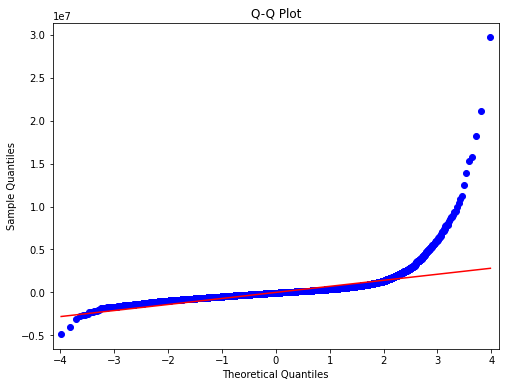

In [71]:
#Linearity
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [72]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(model_final.resid, sm.add_constant(x_final))

(2774.663158194411, 0.0, 34.36720411122348, 0.0)

In [73]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(model_final)

(1.041958978319512, 0.0067385132726375625)

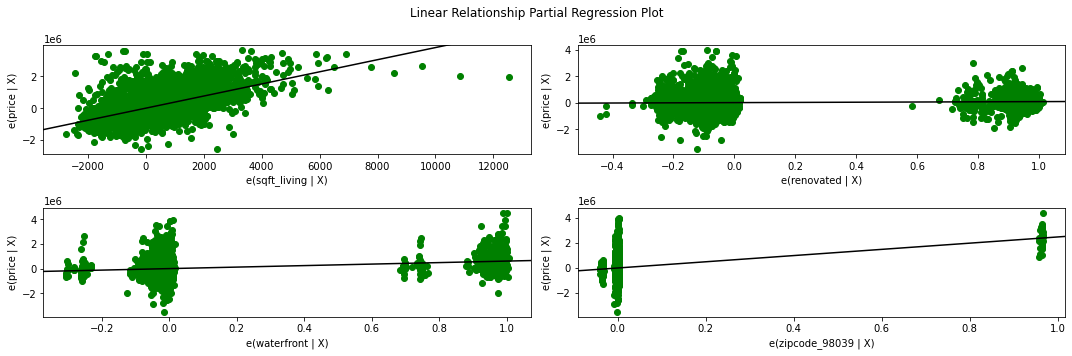

In [74]:
fig = plt.figure(figsize=(15,5))
sm.graphics.plot_partregress_grid(model_final, exog_idx=["sqft_living", "renovated", "waterfront", 'zipcode_98039'], fig=fig)

# Customizing plot appearance; note that the StatsModels code actually uses .plot
# with marker 'o', so what looks like a scatter plot is a "line" internally, so
# we access it using .lines rather than .collections
for ax in fig.axes:
    ax.lines[0].set_color("green")
fig.suptitle("Linear Relationship Partial Regression Plot", fontsize="large")

plt.tight_layout()
plt.show()

In [75]:
model_final_ex = sm.OLS(y_final, sm.add_constant(x_final))

In [76]:
n2 = model_final.nobs

# Taking the middle 50%, so ignoring the first 25% and last 25%
lower_bound = int(np.ceil(n2 * 0.25))
upper_bound = int(np.floor(n2 * 0.75))

# Take subsets of y and X
subset_y = model_final_ex.endog[lower_bound:upper_bound]
subset_X = model_final_ex.exog[lower_bound:upper_bound]

In [77]:
subset_model = sm.OLS(subset_y, subset_X)
subset_results = subset_model.fit()

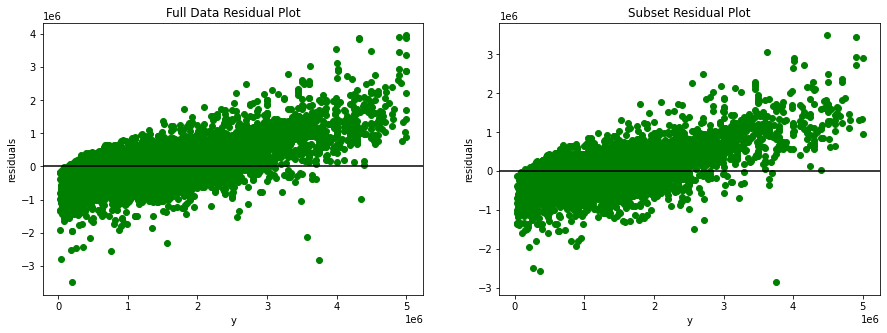

In [78]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].scatter(model_final_ex.endog, model_final.resid, color="green")
axes[0].set_title("Full Data Residual Plot")

axes[1].scatter(subset_y, subset_results.resid, color="green")
axes[1].set_title("Subset Residual Plot")

for ax in axes:
    ax.set_xlabel("y")
    ax.set_ylabel("residuals")
    ax.axhline(y=0, color="black")

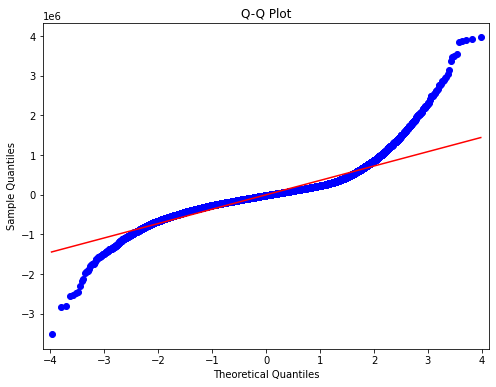

In [79]:
#qq plot to show normality

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_final.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Conclusions

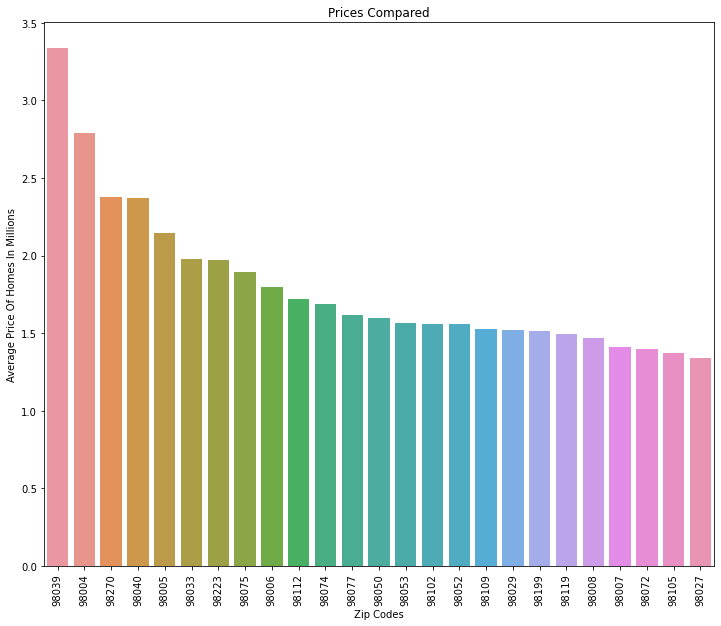

In [80]:
result = df_king_final.groupby(['zipcode'])['price'].mean().sort_values(ascending=False).head(25)
# plot the result
fig, ax = plt.subplots(figsize=(12,10))

g=sns.barplot(x = result.index, y = result.values/1000000, )
g.set_xlabel('Zip Codes')
plt.xticks(rotation=90)
g.set_ylabel('Average Price Of Homes In Millions')
g.set_title('Prices Compared')

plt.savefig('images/Renovationprice.jpg')

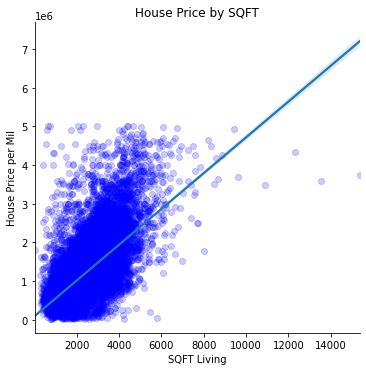

In [81]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", fit_reg=True, scatter_kws = {'color': 'blue', 'alpha': 0.2})
plt.xlabel('SQFT Living')
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT')
plt.savefig('images/sqft_living_final.jpg');

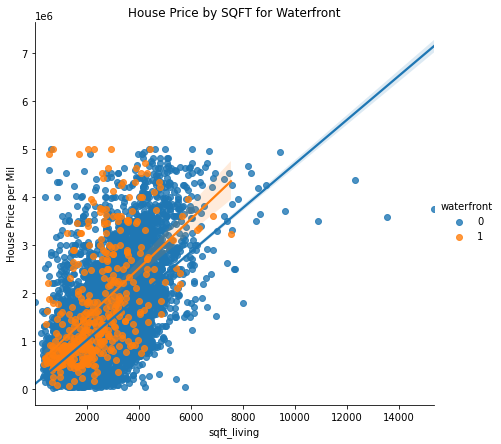

In [94]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='waterfront', height=6, fit_reg=True)
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Waterfront')
plt.savefig('images/Waterfront.jpg');

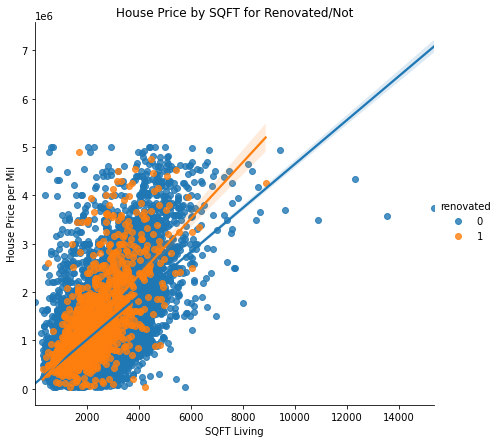

In [83]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='renovated', height=6, fit_reg=True)
plt.xlabel('SQFT Living')
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Renovated/Not')
plt.savefig('images/renovated.jpg');

# Addendum

### Using our model we can estimate Average price of the average sized home located on waterfronts that are due for renovations 

In [84]:
df_waterfront = df_king_final[(df_king_final['waterfront'] == 1) & 
                              (df_king_final['yr_built'] <= 2001) ]
df_waterfront['renovated'].value_counts()

0    304
1     84
Name: renovated, dtype: int64

In [86]:
df_print = df_waterfront.groupby(['renovated'])['price'].mean()
df_print

renovated
0    1.526430e+06
1    1.807126e+06
Name: price, dtype: float64

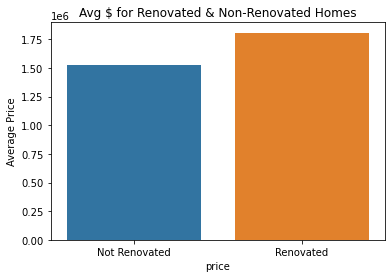

In [98]:
ax = sns.barplot(data=df_print, x=df_print.index, y=df_print.values)

if len(df_print.index) == 2:
    xtick_labels = ['Not Renovated', 'Renovated']
    ax.set_xticklabels(xtick_labels)
else:
    print("Error: There should be exactly two unique values in the 'renovated' column")
    
ax.set_ylabel('Average Price')
ax.set_title('Avg $ for Renovated & Non-Renovated Homes')

plt.savefig('images/water_no_ren.jpg')
plt.show();  

<AxesSubplot:>

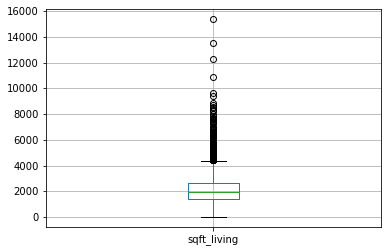

In [99]:
df_king_final.boxplot(column=['sqft_living'])

<AxesSubplot:>

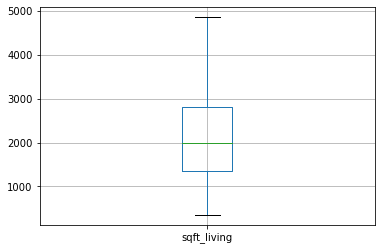

In [100]:
df_waterfront_no_ren = df_waterfront[(df_waterfront['renovated'] == 0) 
                                     & (df_waterfront['sqft_living'] <= 4900)]
df_waterfront_no_ren.boxplot(column=['sqft_living'])

In [101]:
avg_sqft_water2 = df_waterfront_no_ren['sqft_living'].mean()
sqft_coef2 = 382 - 10
water_coef2 = 6100000 - 71000
waterfront_no_ren_estimated_sale_price2 = avg_sqft_water2 * sqft_coef2 + water_coef2
waterfront_no_ren_estimated_sale_price2.astype(int)

6816661

In [102]:
avg_sqft_water = df_waterfront_no_ren['sqft_living'].mean()
sqft_coef = 382 
water_coef = 6100000
waterfront_no_ren_estimated_sale_price = avg_sqft_water * sqft_coef + water_coef
waterfront_no_ren_estimated_sale_price.astype(int)

6908834